# CT 3D Reconstruction with Liver Segmentation

This notebook performs 3D reconstruction of CT images with liver segmentation overlay using ITK.

In [2]:
import numpy as np
import itk
from itkwidgets import view
import os
import glob
from PIL import Image

## Configuration

In [3]:
# Configuration parameters
ct_sequence_dir = 'images_2'  # Directory containing CT PNG sequence
liver_mask_path = 'output_npy'  # Path to liver mask .npy file
target_size = 128  # Target resolution for downsampling (from 512 to 128)

## Load CT PNG Sequence with Downsampling

In [4]:
# Load PNG sequence with downsampling
png_files = sorted(glob.glob(os.path.join(ct_sequence_dir, '*.png')))
if not png_files:
    raise FileNotFoundError(f"No PNG files found in directory: {ct_sequence_dir}")

print(f"Found {len(png_files)} PNG files")

# Load first image to get original dimensions
first_img = Image.open(png_files[0]).convert('L')
original_height, original_width = first_img.size
num_slices = len(png_files)

print(f"Original image dimensions: {original_width}x{original_height}, Slices: {num_slices}")
print(f"Downsampling to {target_size}x{target_size}")

# Create downsampled 3D array from PNG sequence
ct_volume = np.zeros((num_slices, target_size, target_size), dtype=np.float32)

for i, png_file in enumerate(png_files):
    img = Image.open(png_file).convert('L')
    
    # Downsample using PIL's resize with antialiasing
    img_resized = img.resize((target_size, target_size), Image.Resampling.LANCZOS)
    ct_volume[i] = np.array(img_resized, dtype=np.float32)

print(f"CT volume shape after downsampling: {ct_volume.shape}")

Found 108 PNG files
Original image dimensions: 512x512, Slices: 108
Downsampling to 128x128
CT volume shape after downsampling: (108, 128, 128)


## Load Liver Mask with Downsampling

In [5]:
# Load liver mask slices with downsampling
try:
    if os.path.isdir(liver_mask_path):
        print(f"Loading mask slices from directory: {liver_mask_path}")
        
        # Find all mask .npy files and sort them
        mask_files = sorted(glob.glob(os.path.join(liver_mask_path, '*_mask.npy')))
        if not mask_files:
            raise FileNotFoundError(f"No mask .npy files found in directory: {liver_mask_path}")
        
        print(f"Found {len(mask_files)} mask slice files")
        
        # Create downsampled 3D mask volume
        liver_mask = np.zeros((len(mask_files), target_size, target_size), dtype=np.float32)
        
        for i, mask_file in enumerate(mask_files):
            mask_slice = np.load(mask_file)
            
            # Convert to PIL Image for downsampling
            mask_img = Image.fromarray(mask_slice.astype(np.uint8))
            
            # Downsample using nearest neighbor to preserve binary nature
            mask_resized = mask_img.resize((target_size, target_size), Image.Resampling.NEAREST)
            liver_mask[i] = np.array(mask_resized, dtype=np.float32)
        
        print(f"Liver mask volume created with shape: {liver_mask.shape}")
        
    else:
        # It's a single file, load directly
        liver_mask = np.load(liver_mask_path)
        print(f"Liver mask loaded with shape: {liver_mask.shape}")
        
except Exception as e:
    raise FileNotFoundError(f"Error loading liver mask: {str(e)}")

# Ensure dimensions match
if liver_mask.shape != ct_volume.shape:
    print(f"Warning: Shape mismatch - CT: {ct_volume.shape}, Mask: {liver_mask.shape}")
    
    # Try squeezing if there's an extra dimension
    if liver_mask.shape[0] == 1 and len(liver_mask.shape) == 4:
        liver_mask = np.squeeze(liver_mask, axis=0)
        print(f"Squeezed mask to shape: {liver_mask.shape}")
    
    if liver_mask.shape != ct_volume.shape:
        raise ValueError(f"Cannot match CT and mask dimensions")

print(f"Final liver mask shape: {liver_mask.shape}")
print(f"Liver mask unique values: {np.unique(liver_mask)}")

Loading mask slices from directory: output_npy
Found 108 mask slice files
Liver mask volume created with shape: (108, 128, 128)
Final liver mask shape: (108, 128, 128)
Liver mask unique values: [  0. 255.]


## Create Enhanced Volume with Liver Highlight

In [6]:
# Normalize CT volume to 0-255 range for visualization
ct_normalized = ((ct_volume - ct_volume.min()) / (ct_volume.max() - ct_volume.min()) * 255).astype(np.uint8)

# Create enhanced CT volume with liver highlight
liver_enhancement = 50  # Enhancement factor for liver region
enhanced_ct = ct_normalized.astype(np.float32) + liver_mask.astype(np.float32) * liver_enhancement

# Clip values to valid range
enhanced_ct = np.clip(enhanced_ct, 0, 255).astype(np.uint8)

print(f"Enhanced CT volume created with liver highlight")
print(f"CT range: [{ct_normalized.min()}, {ct_normalized.max()}]")
print(f"Enhanced CT range: [{enhanced_ct.min()}, {enhanced_ct.max()}]")

Enhanced CT volume created with liver highlight
CT range: [0, 255]
Enhanced CT range: [0, 255]


## 3D Visualization

ITK image created with default spacing: [1.0, 1.0, 0.8]
Launching 3D visualization...



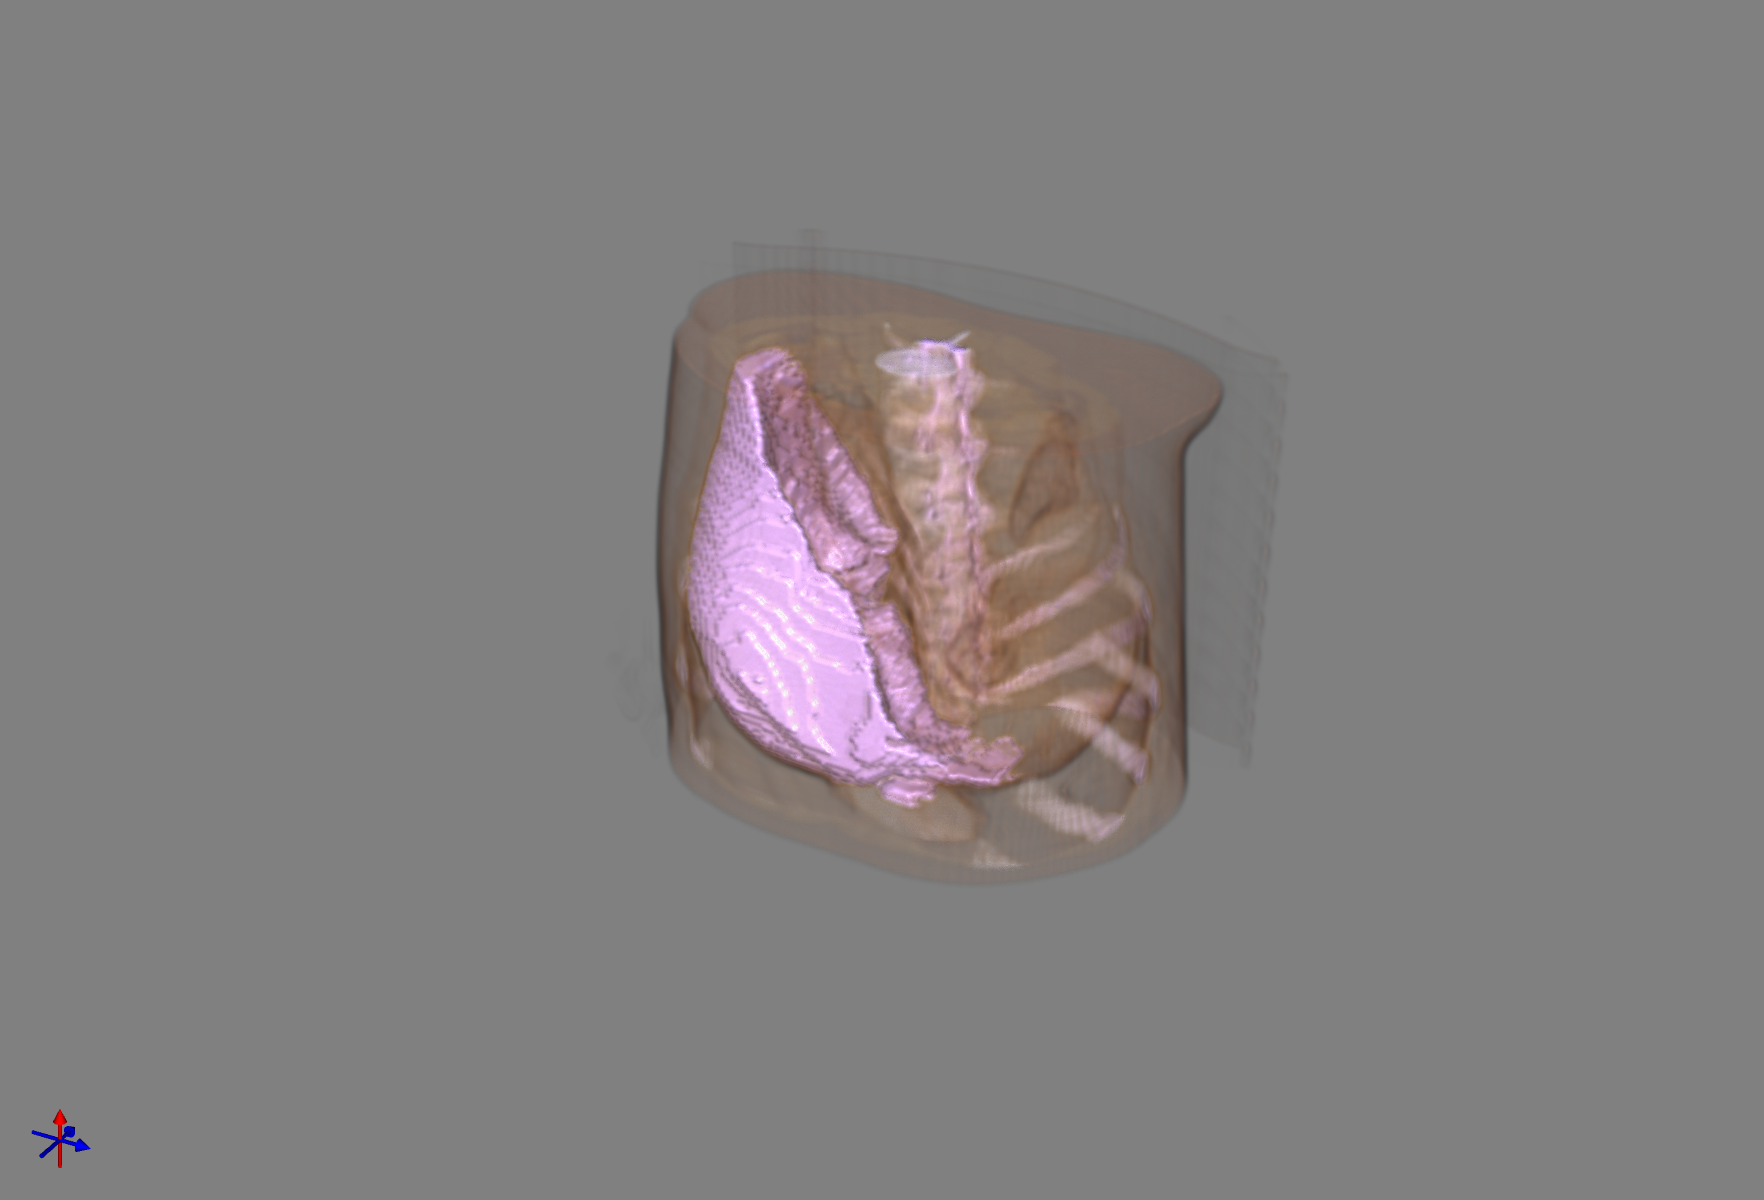
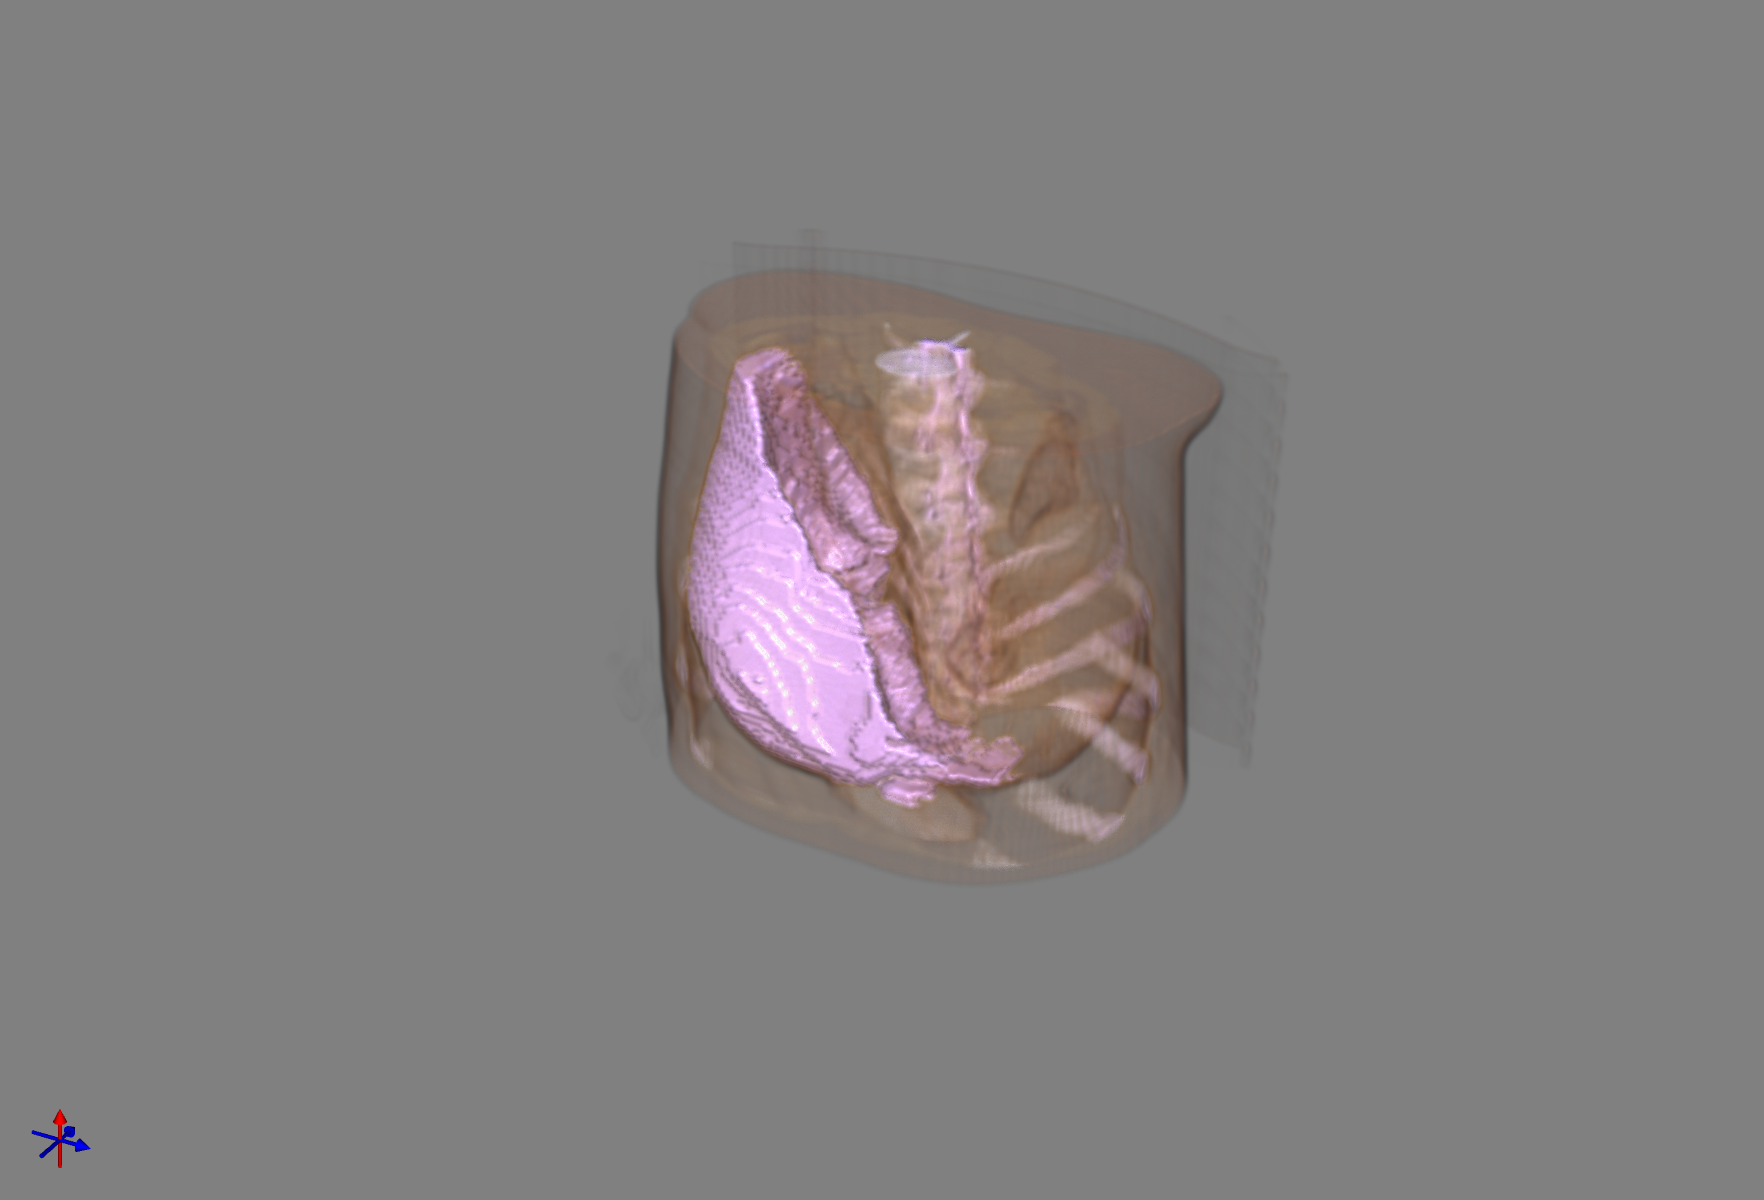

<IPython.core.display.Javascript object>

In [7]:
# Convert to ITK image and visualize
itk_image = itk.image_from_array(enhanced_ct)

# Set default spacing
itk_image.SetSpacing([1.0, 1.0, 0.8])
itk_image.SetOrigin([0.0, 0.0, 0.0])

print("ITK image created with default spacing: [1.0, 1.0, 0.8]")
print("Launching 3D visualization...")

# Display 3D visualization
view(itk_image)